In [1]:
import os
import time
import json
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import cProfile, pstats

from core.env.scene_manager import SceneManager
from core.env.scene_manager import show_valid_score_map, draw_dependency_graph

phi: 0.217 | uniform size: (19, 19)
Manipulator at [49, 49]


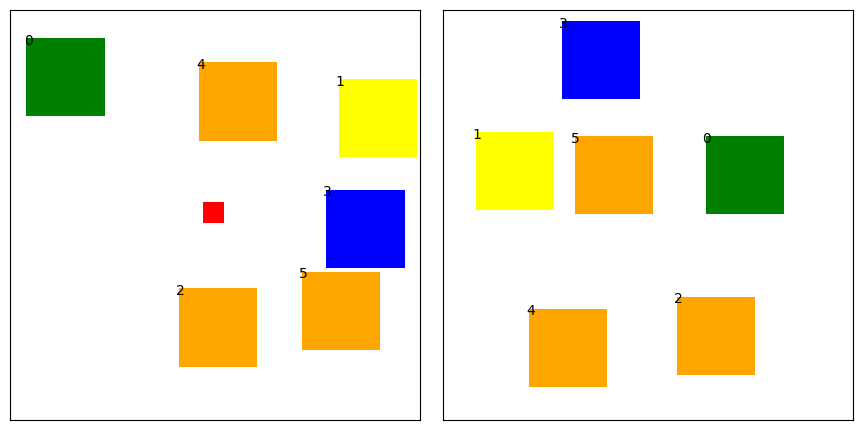

In [2]:
phi = 0.2
num_objects = 6
grid_size = (100, 100)

env = SceneManager(
	mode='stationary', num_objects=num_objects, 
	grid_size=grid_size, phi=phi, 
	terminal_cost=True, verbose=1
)
env.reset(use_stack=False, use_sides=False)
initial_scene, target_scene = env.initial_x.clone(), env.target_x.clone()
# with open(f'example_phi{phi}_n{num_objects}.pkl', 'rb') as f:
# 	scenes = pickle.load(f)
# 	initial_scene = scenes["initial"].x.to(torch.long)
# 	target_scene = scenes["target"].x.to(torch.long)
env.reset(initial_scene, target_scene)
env.render(show_manipulator=True)
# show_valid_score_map(env, obj=0)
# draw_dependency_graph(env, fig_size=(3, 3))

# Planners

In [3]:
import heapq
from typing import Optional
from core.env.scene_manager import (
	Indices, copy_state, state_to_hashable,
    get_object_below, get_object_above, get_object_base, build_parent_of
)

def env_cost(env, actions, initial_scene, target_scene, log=True):
	env.reset(initial_scene, target_scene)
	if actions is None:
		return None
	
	ep_cost = 0
	for action in actions:
		ep_cost += env.step(action, log=log)[0]
	if log:
		print(f'episode cost: {ep_cost:.3f}')
	env.reset(initial_scene, target_scene)
	return ep_cost

def evaluate_alg(env, alg, initial_scene, target_scene, num_runs=1, **kwargs):
	plan = None
	steps, costs, elapsed_time = [], [], []
	best_cost = np.inf

	print(f"--------{alg.__name__}--------")
	if num_runs > 1:
		pbar = tqdm(total=num_runs, desc=f"Evaluating {alg.__name__}", unit="run")
	
	for _ in range(num_runs):
		env.reset(initial_scene, target_scene)
		cost = None
		plan_i, steps_i, elapsed_time_i = alg(env).solve(**kwargs)
		if plan_i:
			cost = env_cost(env, plan_i, initial_scene, target_scene, log=False)
			if cost < best_cost:
				plan = plan_i
			costs.append(cost)
			steps.append(steps_i)
			elapsed_time.append(elapsed_time_i)

		if num_runs > 1:
			pbar.update(1)
			pbar.set_postfix(cost=cost, steps=steps_i, elapsed_time=elapsed_time_i)
		else:
			elapsed_time = elapsed_time_i
			steps = steps_i
	
	if num_runs > 1:
		pbar.close()
		print(f'mean cost: {np.mean(costs):.2f} | mean elapsed_time: {np.mean(elapsed_time):.3f}s | mean steps: {np.mean(steps):.2f}')
	else:
		print(f'plan: {plan}')
		print(f'elapsed_time: {elapsed_time:.3f}s')
		print(f'steps: {steps}')

		if plan is not None:
			env_cost(env, plan, initial_scene, target_scene)

	env.reset(initial_scene, target_scene)
	return plan

def reconstruct_path(node):
    path = []
    while node.parent is not None:
        path.append(node.action)
        node = node.parent
    path.reverse()
    return path

class BaseSearch:
	def __init__(self, env, node_class):
		"""
		Base class for search algorithms.
		:param env: The environment in which the search is performed.
		:param node_class: The class used for representing nodes in the search.
		"""
		self.env = env
		self.node_class = node_class  # Generalized node class


### Labbe

In [4]:
class LabbeNode:
	node_counter = 0  # Static variable to assign unique IDs to each node

	def __init__(self, state, remaining_objs, obj=None, parent=None, action=None, c=1, depth=0):
		self.state = state
		self.obj = obj
		self.parent = parent
		self.action = action
		self.children = {}
		self.n = 0
		self.w = 0.0
		self.c = c
		self.remaining_objs = remaining_objs
		self.depth = depth
		
		# Assign a unique ID to each node
		self.id = LabbeNode.node_counter
		LabbeNode.node_counter += 1

	def get_state(self):
		return copy_state(self.state)

	def is_fully_expanded(self):
		return len(self.remaining_objs) == 0

	def ucb(self):
		expected_value = self.w / self.n
		exploration_term = self.c * np.sqrt(2 * np.log(self.parent.n) / self.n)

		return expected_value + exploration_term

class LabbeMCTS(BaseSearch):
	def __init__(self, env):
		super().__init__(env, LabbeNode)

	def get_remaining_objs(self, state: dict) -> list:
		raise NotImplementedError

	def evaluate_state(self, state: dict) -> float:
		raise NotImplementedError

	def get_action_move_obj_away(self, k: int) -> Optional[int]:
		raise NotImplementedError

	def get_motion(self, k: int) -> Optional[int]:
		raise NotImplementedError

	def select(self, node):
		# Accesses child nodes for best selection
		return max(node.children.values(), key=lambda child: child.ucb())

	def expand(self, node):
		# Prevents further expansion if no actions remain
		if node.is_fully_expanded():
			return None

		# If the node is too deep, we stop expanding to avoid infinite loops
		if node.depth > 2*self.env.N + 2:
			return None

		action = self.get_motion(node.remaining_objs.pop())
		if action is None:
			return self.expand(node)

		action_type, start_obj, target_obj, coord = self.env.decode_action(action)

		# Continue expanding if the last changed obj is the same as the current obj
		# if node.obj == start_obj:
		# 	return self.expand(node)

		_, child_state = self.env._step(action_type, start_obj, target_obj, coord)

		if torch.equal(child_state['current'], node.state['current']):
			raise ValueError('State has not changed')

		child_node = self.node_class(
			state=child_state, 
			remaining_objs=self.get_remaining_objs(child_state), 
			obj=start_obj, 
			parent=node, 
			action=action, 
			c=node.c,
			depth=node.depth+1
		)
		node.children[action] = child_node

		return child_node

	def backup_search(self, node, value):
		while node is not None:
			node.n += 1
			node.w += value
			node = node.parent

	def print_tree(self, node, depth=0):
		# Print the current node with indentation to show its depth in the tree
		indent = "    " * depth  # Four spaces per level of depth
		if node.id == 0:
			print(f"Root | Visits: {node.n} | Value: {node.w:.2f}")
		else:
			print(f"{indent}ID: {node.id} | Action: {node.action} | "
					f"Visits: {node.n} | Value: {node.w:.2f}")

		# Sort children by value estimate
		children = sorted(node.children.values(), key=lambda child: child.w / child.n if child.n > 0 else float('inf'))

		# Recurse on children
		for child in children:
			self.print_tree(child, depth + 1)

	def loop(self):
		node = self.root_node

		# Selection
		while node.is_fully_expanded():
			node = self.select(node)

		# Expansion
		self.env.set_state(node.get_state())
		child_node = self.expand(node)
		if child_node is not None:
			node = child_node
			if self.env.is_terminal_state(node.state):
				self.terminal_node = node
				return
			value = self.evaluate_state(node.state)
		else:
			# It means it fully expanded
			while len(node.children) == 0 and node.parent:
				node.parent.children.pop(node.action)
				node = node.parent
			value = 0

		# Backpropagation
		self.backup_search(node, value)

	def _solve(self, c: float=0.1, verbose: int=0, time_limit: int=1000):
		start_time = time.time()
		self.terminal_node = None
		LabbeNode.node_counter = 0
		steps = 0

		if self.env.is_terminal_state():
			print('The initial scene is already in the target state.')
			return [], steps, time.time()-start_time

		root_state = self.env.get_state()
		self.root_node = self.node_class(
			state=root_state, 
			remaining_objs=self.get_remaining_objs(root_state), 
			c=c
		)

		if verbose > 0:
			pbar = tqdm(total=None, unit='iterations')

		while self.terminal_node is None:
			# Check if the elapsed time has exceeded the limit
			if time.time()-start_time > time_limit:
				if verbose > 0:
					pbar.close() # type: ignore
				return None, steps, time.time()-start_time

			steps += 1
			self.loop()
			if verbose > 0:
				pbar.update(1) # type: ignore
			
			if len(self.root_node.children) == 0:
				print('No more actions to expand for root node')
				if verbose > 0:
					pbar.close() # type: ignore
				return None, steps, time.time()-start_time

		if verbose > 0:
			pbar.close() # type: ignore

		return reconstruct_path(self.terminal_node), steps, time.time()-start_time

class Labbe(LabbeMCTS):
	def get_remaining_objs(self, state: dict) -> list:
		"""
		Objects whose current center ≠ target center.
		"""
		current_x, target_x = state['current'], self.env.target_x

		# All current vs. target centers: [N,2]
		cur_centers = current_x[:, Indices.COORD]
		tgt_centers = target_x[:, Indices.COORD]

		# Base condition for objs that should be on the table
		satisfied = (cur_centers == tgt_centers).all(dim=1)  # [N]

		# Remaining = those not satisfied
		rem = torch.nonzero(~satisfied, as_tuple=False).view(-1)  # [R]

		if rem.numel() == 0:
			return []

		# Shuffle the remaining indices
		perm = torch.randperm(rem.size(0))
		return rem[perm].tolist()

	def evaluate_state(self, state: dict) -> float:
		"""
		Fraction of objects exactly at their target centers.
		"""
		current_x, target_x = state['current'], self.env.target_x

		cur_centers = current_x[:, Indices.COORD]       
		tgt_centers = target_x[:, Indices.COORD]  

		satisfied = (cur_centers == tgt_centers).all(dim=1)  # [N]
		return satisfied.float().mean().item()

	def get_action_move_obj_away(self, k: int) -> Optional[int]:
		"""
		Moves object k to it's target position,
		o.w. moves it randomly.
		"""
		# Is target position free?
		TK = self.env.target_x[k, Indices.COORD]
		if not self.env.is_invalid_center(TK, k):
			return self.env.encode_move(k, TK)

		# Move away k
		free_positions = self.env.get_empty_positions(ref_obj=k, n=1)
		if free_positions.numel() > 0:
			# move to a random position
			return self.env.encode_move(k, free_positions[0])
		return None

	def get_motion(self, k: int) -> Optional[int]:
		"""
		Move object k to its target position if it was free,
		o.w. move away one of its blocking objects
		"""
		CK = self.env.current_x[k, Indices.COORD]
		TK = self.env.target_x[k, Indices.COORD]
		if torch.equal(TK, CK):
			raise ValueError(f'The obj {k} is already in its target position')
		
		# Is target position free?
		if not self.env.is_invalid_center(TK, k):
			return self.env.encode_move(k, TK)

		# Move away one of its blocking objects
		occupants = self.env.find_blocking_objects(k)
		if len(occupants) == 0:
			raise ValueError('No obj is occupying the target position')
		for j in occupants:
			action_away = self.get_action_move_obj_away(j)
			if action_away is not None:
				return action_away
		return None

	def solve(self, c: float=0.1, verbose: int=0, time_limit: int=1000):
		if torch.sum(self.env.initial_x[:, Indices.RELATION]) > 0:
			raise ValueError('Initial scene has stacks in Non-stack mode')
		if torch.sum(self.env.current_x[:, Indices.RELATION]) > 0:
			raise ValueError('Current scene has stacks in Non-stack mode')
		if torch.sum(self.env.target_x[:, Indices.RELATION]) > 0:
			raise ValueError('Target scene has stacks in Non-stack mode')
		return self._solve(c, verbose, time_limit)

class Labbe_S(LabbeMCTS):
	def get_remaining_objs(self, state: dict) -> list:
		"""
		• Objects whose aren't stacked on their target objects.
		• Base objects whose current center ≠ target center.
		"""
		current_x, target_x = state['current'], self.env.target_x

		# Build parent‐of maps once
		cur_parent = build_parent_of(current_x)

		# Stacking condition for objs that should be stacked
		cond_stacked = (self.tgt_parent >= 0) & (cur_parent == self.tgt_parent)

		# Base condition for objs that should be on the table
		cur_centers = current_x[:, Indices.COORD]
		tgt_centers = target_x[:, Indices.COORD]
		base_match = (cur_centers == tgt_centers).all(dim=1)  # [N]
		cond_base    = (self.tgt_parent < 0) & (cur_parent < 0) & base_match

		# Satisfied = either stacking OK or base OK
		satisfied = cond_stacked | cond_base       # [N]

		# Remaining = those not satisfied
		rem = torch.nonzero(~satisfied, as_tuple=False).view(-1)  # [R]

		if rem.numel() == 0:
			return []

		# Shuffle the remaining indices
		perm = torch.randperm(rem.size(0))
		return rem[perm].tolist()

	def evaluate_state(self, state) -> float:
		"""
		Fraction of nodes satisfying the same two conditions:
		• stacked correctly, or
		• matched centers of base objects.
		"""
		current_x, target_x = state['current'], self.env.target_x

		cur_parent = build_parent_of(current_x)

		cur_centers = current_x[:, Indices.COORD]
		tgt_centers = target_x[:, Indices.COORD]
		base_match = (cur_centers == tgt_centers).all(dim=1)  # [N]

		cond_stacked = (self.tgt_parent >= 0) & (cur_parent == self.tgt_parent)
		cond_base    = (self.tgt_parent < 0) & (cur_parent < 0) & base_match

		satisfied = cond_stacked | cond_base
		return satisfied.float().mean().item()

	def get_action_move_obj_away(self, k: int) -> Optional[int]:
		"""
		Moves object k to it's target position or target stack,
		o.w. moves it randomly or stacks it randomly.
		"""
		# Non-empty objects cannot be moved in static_stack mode
		if self.static_stack:
			j = get_object_above(self.env.current_x, k)
			if j is not None:
				return None

		# Is target object empty?
		i = get_object_below(self.env.target_x, k)
		if i is not None:
			if not get_object_above(self.env.current_x, i):
				return self.env.encode_stack(k, i)

		# Is target position free?
		TK = self.env.target_x[k, Indices.COORD]
		if not self.env.is_invalid_center(TK, k):
			return self.env.encode_move(k, TK)

		# Move away k
		free_positions = self.env.get_empty_positions(ref_obj=k, n=1)
		free_objects = self.env.get_empty_objs(ref_obj=k, n=1)
		if len(free_objects) > 0 and free_positions.numel() > 0:
			if np.random.rand() < 0.5:
				# move to a random position
				return self.env.encode_move(k, free_positions[0])
			else:
				# stack on a random object
				return self.env.encode_stack(k, free_objects[0])
		elif len(free_objects) == 0 and free_positions.numel() > 0:
			# move to a random position
			return self.env.encode_move(k, free_positions[0])
		elif free_positions.numel() == 0 and len(free_objects) > 0:
			# stack on a random object
			return self.env.encode_stack(k, free_objects[0])
		return None

	def get_motion(self, k: int) -> Optional[int]:
		"""
		Moves object k to it's target position or target stack,
		o.w. move away one of it's blocking objects.
		"""
		# Non-empty objects cannot be moved in static_stack mode
		if self.static_stack:
			j = get_object_above(self.env.current_x, k)
			if j is not None:
				return self.get_action_move_obj_away(j)

		# Is target object empty?
		i = get_object_below(self.env.target_x, k)
		if i is not None:
			j = get_object_above(self.env.current_x, i)
			if j is not None:
				return self.get_action_move_obj_away(j)
			return self.env.encode_stack(k, i)

		CK = self.env.current_x[k, Indices.COORD]
		TK = self.env.target_x[k, Indices.COORD]
		if torch.equal(TK, CK):
			j = get_object_below(self.env.current_x, k)
			if j is not None:
				j = get_object_base(self.env.current_x, j)
				return self.get_action_move_obj_away(j)
			raise ValueError(f'The obj {k} is already in its target position')

		# Is target position free?
		if not self.env.is_invalid_center(TK, k):
			return self.env.encode_move(k, TK)

		# Move away one of its blocking objects
		occupying_nodes = self.env.find_blocking_objects(k)
		if len(occupying_nodes) == 0:
			raise ValueError('No node is occupying the target position')
		for j in occupying_nodes:
			action_away = self.get_action_move_obj_away(j)
			if action_away is not None:
				return action_away
		return None

	def solve(self, c: float=0.1, static_stack: bool=False, verbose: int=0, time_limit: int=1000):
		self.static_stack = static_stack
		self.tgt_parent = build_parent_of(self.env.target_x)
		return self._solve(c, verbose, time_limit)

evaluate_alg(env, Labbe, initial_scene, target_scene, num_runs=10, c=0.1, time_limit=20);
evaluate_alg(env, Labbe_S, initial_scene, target_scene, num_runs=10, c=0.1, time_limit=20);

--------Labbe--------


Evaluating Labbe: 100%|██████████| 10/10 [00:00<00:00, 16.93run/s, cost=8.29, elapsed_time=0.0365, steps=21]


mean cost: 7.55 | mean elapsed_time: 0.042s | mean steps: 21.70
--------Labbe_S--------


Evaluating Labbe_S: 100%|██████████| 10/10 [00:00<00:00, 19.62run/s, cost=7.21, elapsed_time=0.0375, steps=22]

mean cost: 7.56 | mean elapsed_time: 0.038s | mean steps: 21.90


### Sorp

In [5]:
class MctsNode:
	node_counter = 0  # Static variable to assign unique IDs to each node

	def __init__(self, state, valid_actions, parent=None, action=None, cost=0.0, cost_to_come=0.0, c=1, depth=0):
		self.state = state
		self.parent = parent
		self.action = action
		self.children = {}
		self.n = 0
		# self.w = 0
		self.w = np.inf
		self.c = c
		self.cost = cost
		self.cum_cost = cost_to_come
		self.unexpanded_actions = valid_actions
		self.depth = depth
		
		# Assign a unique ID to each node
		self.id = MctsNode.node_counter
		MctsNode.node_counter += 1

	def get_state(self):
		return copy_state(self.state)

	def is_fully_expanded(self):
		return len(self.unexpanded_actions) == 0

	def uct(self, c_min=0, c_max=1):
		n = self.n

		# expected_value = ( (self.cum_cost + self.w / n) - c_min ) / (c_max - c_min)
		expected_value = ( (self.cum_cost + self.w) - c_min ) / (c_max - c_min)
		exploration_term = np.sqrt(2 * np.log(self.parent.n) / n)

		return expected_value - self.c * exploration_term  # Minimization form

class Sorp(BaseSearch):
	def __init__(self, env):
		super().__init__(env, MctsNode)
	
	def get_remaining_objs(self, state: dict) -> list:
		"""
		• Objects whose aren't stacked on their target objects.
		• Base objects whose current center ≠ target center.
		"""
		current_x, target_x = state['current'], self.env.target_x

		# Build parent‐of maps once
		cur_parent = build_parent_of(current_x)

		# Stacking condition for objs that should be stacked
		cond_stacked = (self.tgt_parent >= 0) & (cur_parent == self.tgt_parent)

		# Base condition for objs that should be on the table
		cur_centers = current_x[:, Indices.COORD]
		tgt_centers = target_x[:, Indices.COORD]
		base_match = (cur_centers == tgt_centers).all(dim=1)  # [N]
		cond_base    = (self.tgt_parent < 0) & (cur_parent < 0) & base_match

		# Satisfied = either stacking OK or base OK
		satisfied = cond_stacked | cond_base       # [N]

		# Remaining = those not satisfied
		rem = torch.nonzero(~satisfied, as_tuple=False).view(-1)  # [R]

		if rem.numel() == 0:
			return []

		# Shuffle the remaining indices
		perm = torch.randperm(rem.size(0))
		return rem[perm].tolist()

	def get_valid_actions(self, state: dict) -> list:
		"""
		...
		"""
		# restore the env to this state
		self.env.set_state(copy_state(state))

		rem = self.get_remaining_objs(state)          # Python list of ints
		if len(rem) == 0:
			return []

		# Which k are allowed (static_stack skips non‐empty actors)
		if self.static_stack:
			rem = torch.tensor(rem, dtype=torch.long)
			rel     = self.env.current_x[:, Indices.RELATION]
			empty_k = ~rel.any(dim=0)                  # True if k has no one on top
			mask = empty_k[rem]
			ks = rem[mask].tolist()
		else:
			ks = rem

		valid_actions = []
		stack_nums = max(int(0.6 * self.num_buffers), 1)

		for k in ks:
			valid_stacks = []
			objs = self.env.get_empty_objs(ref_obj=k, n=stack_nums)
			if len(objs) > 0:
				M      = len(objs)
				starts = torch.full((M,), k, dtype=torch.long)
				targets= torch.tensor(objs, dtype=torch.long)
				valid_stacks = self.env.encode_stack(starts, targets).tolist()

			valid_moves = []
			coords = self.env.get_empty_positions_with_target(
				ref_obj=k,
				n=self.num_buffers-len(valid_stacks),
				sort=self.score_sorting
			)

			if coords.numel() > 0:
				M      = coords.size(0)
				starts = torch.full((M,), k, dtype=torch.long)
				valid_moves  = self.env.encode_move(starts, coords).tolist()

			valid_actions += valid_stacks + valid_moves

		return valid_actions

	def select(self, node):
		# Accesses child nodes for best selection
		if self.c_min == np.inf or self.c_max == self.c_min:
			return min(node.children.values(), key=lambda child: child.uct())
		else:
			return min(node.children.values(), key=lambda child: child.uct(self.c_min, self.c_max))

	def expand(self, node):
		if node.is_fully_expanded():
			return None  # Prevents further expansion if no actions remain

		action = node.unexpanded_actions.pop()
		self.env.set_state(node.get_state())
		action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

		# Continue expanding if the last changed node is the same as the current node
		if node.action is not None:
			_, last_obj, _, _ = self.env.decode_action(node.action)
			if last_obj == start_obj:
				return self.expand(node)

		cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

		# Continue expanding if the state hasn't changed
		if torch.equal(child_state['current'], node.state['current']):
			raise ValueError('State has not changed')

		child_node = self.node_class(
			state=child_state, 
			valid_actions=self.get_valid_actions(self.env.get_state()), 
			parent=node, 
			action=action, 
			cost=cost, 
			cost_to_come=cost+node.cum_cost,
			c=node.c, 
			depth=node.depth+1
		)
		node.children[action] = child_node

		return child_node

	def rollout_one(self, node):
		costs = 0

		self.env.set_state(node.get_state())
		sim_time_limit = (self.time_limit - time.time() + self.start_time) / 4
		feasible_path, steps, _ = Labbe_S(self.env).solve(time_limit=sim_time_limit, static_stack=self.static_stack)
		self.env.set_state(node.get_state())

		if feasible_path:
			for i, action in enumerate(feasible_path):
				cost, child_state = self.env.step(action)
				costs += cost
				if i == 0:
					# remove action from the node's unexpanded actions
					if action in node.unexpanded_actions:
						node.unexpanded_actions.remove(action)
					# add the new child to the node
					child_node = self.node_class(
						state=child_state, 
						valid_actions=self.get_valid_actions(child_state), 
						parent=node, 
						action=action, 
						cost=cost, 
						cost_to_come=cost+node.cum_cost,
						c=node.c, 
						depth=node.depth+1
					)
					node.children[action] = child_node
					node = child_node

		return costs, steps, feasible_path, node

	def rollout_whole(self, node):
		costs = 0

		self.env.set_state(node.get_state())
		sim_time_limit = (self.time_limit - time.time() + self.start_time) / 4
		feasible_path, steps, _ = Labbe_S(self.env).solve(time_limit=sim_time_limit, static_stack=self.static_stack)
		self.env.set_state(node.get_state())

		if feasible_path:
			for action in feasible_path:
				cost, child_state = self.env.step(action)
				costs += cost
				# remove action from the node's unexpanded actions
				if action in node.unexpanded_actions:
					node.unexpanded_actions.remove(action)
				# add the new child to the node
				child_node = self.node_class(
					state=child_state, 
					valid_actions=self.get_valid_actions(child_state), 
					parent=node, 
					action=action, 
					cost=cost, 
					cost_to_come=cost+node.cum_cost,
					c=node.c, 
					depth=node.depth+1
				)
				node.children[action] = child_node
				node = child_node

		return costs, steps, feasible_path, node

	def rollout(self, node):
		if self.one_step:
			return self.rollout_one(node)
		else:
			return self.rollout_whole(node)

	def backup_search(self, node, value):
		while node is not None:
			node.n += 1
			# node.w += value
			node.w = min(node.w, value)
			value += node.cost
			node = node.parent

	def print_tree(self, node, depth=0, max_depth=float('inf'), ter=False):
		if depth >= max_depth:
			return

		# Print the current node with indentation to show its depth in the tree
		indent = "    " * depth  # Four spaces per level of depth
		if node.id == 0:
			print(f"Root | n: {node.n} | w: {node.w:.2f}")
		else:
			n = node.n
			if self.c_max == self.c_min:
				# expected_value = node.cum_cost + node.w / n
				expected_value = node.cum_cost + node.w
			else:
				# expected_value = ( (node.cum_cost + node.w / n) - self.c_min ) / (self.c_max - self.c_min)
				expected_value = ( (node.cum_cost + node.w) - self.c_min ) / (self.c_max - self.c_min)
			exploration_term = np.sqrt(2 * np.log(node.parent.n) / n)

			print(f"{indent}ID: {node.id} | a: {node.action} | c: {node.cost:.2f} | ctc: {node.cum_cost:.2f} | "
					f"n: {node.n} | w: {node.w:.2f} | expe: {expected_value:.4f} | expl: {exploration_term:.4f}")

		# Sort children by w estimate
		if ter:
			accepted_children = [child for child in node.children.values()]
			children = sorted(accepted_children, key=lambda child: child.w)
		else:
			children = sorted(node.children.values(), key=lambda child: child.w)

		# Recurse on children
		for child in children:
			self.print_tree(child, depth + 1, max_depth, ter)

	def find_best_path(self):
		# self.print_tree(self.root_node, max_depth=5)
		if self.best_plan is None or self.best_plan[1] is None:
			return None
		return reconstruct_path(self.best_plan[0]) + self.best_plan[1]

	def loop(self):
		node = self.root_node

		# Selection
		self.env.set_state(node.get_state())
		while node.is_fully_expanded() and not self.env.is_terminal_state():
			node = self.select(node)
			self.env.set_state(node.get_state())

		# Expansion
		if not self.env.is_terminal_state():
			child_node = self.expand(node)
			if child_node is None:
				while len(node.children) == 0 and node.is_fully_expanded():
					node.parent.children.pop(node.action)
					node = node.parent
					print('oooooooooooooooooooo laaaaaaaa laaaaaaaaaaaaa')
				return 1
			node = child_node

		# Simulation (Rollout)
		self.env.set_state(node.get_state())
		steps = 0
		if self.env.is_terminal_state():
			value = 0
		else:
			c_rollout, steps, feasible_plan, child_node = self.rollout(node)

			if feasible_plan is None:
				if node.parent is None:
					return -1
				node.parent.children.pop(node.action)
				node = node.parent
				while len(node.children) == 0 and node.is_fully_expanded():
					node.parent.children.pop(node.action)
					node = node.parent
					if node.parent is None:
						return -1
				return steps

			new_cost = c_rollout + node.cum_cost
			self.c_max = max(self.c_max, new_cost)
			if new_cost < self.c_min:
				self.best_plan = (node, feasible_plan)
				self.c_min = new_cost
			
			node = child_node
			if self.one_step:
				value = c_rollout - node.cost
				# value = c_rollout
			else:
				value = 0

		# Backpropagation
		self.backup_search(node, value)

		return steps

	def solve(
			self, iterations: int=1000, 
			num_buffers: int=4, score_sorting: bool=False,
			c: float=1, verbose: int=0, 
			one_step: bool=True, static_stack: bool=False, 
			time_limit: int=1000
		):
		self.start_time = time.time()
		self.static_stack = static_stack
		self.score_sorting = score_sorting
		self.tgt_parent = build_parent_of(self.env.target_x)

		MctsNode.node_counter = 0
		self.num_buffers = num_buffers
		self.time_limit = time_limit
		self.one_step = one_step
		self.c_max = -np.inf
		self.c_min = np.inf
		self.best_plan = None
		window_last_values = []
		self.root_node = self.node_class(
			state=self.env.get_state(), 
			valid_actions=self.get_valid_actions(self.env.get_state()), 
			c=c
		)
		
		steps, iteration = 0, 0
		if verbose > 0:
			pbar = tqdm(total=None, unit='iterations')
		
		while iteration < iterations:
			# Check if the elapsed time has exceeded the limit
			if time.time()-self.start_time > time_limit:
				if verbose > 0:
					pbar.close()
				print('Time limit exceeded')
				return self.find_best_path(), steps, time.time()-self.start_time
			
			iteration += 1
			step = self.loop()
			if step == -1:
				return self.find_best_path(), steps, time.time()-self.start_time
			
			steps += step
			if verbose > 0:
				pbar.update(1)
			
			# if iteration != 0 and iteration % 10 == 0:
			# 	v_root = self.root_node.w
			# 	print(f'v_root: {v_root:.3f} | c_min: {self.c_min:.3f} | c_max: {self.c_max:.3f}')
			# 	self.print_tree(self.root_node, max_depth=3)
			# 	window_last_values.append(self.c_min)
			# 	if len(window_last_values) > 5:
			# 		window_last_values.pop(0)
			# 		if len(set(window_last_values)) == 1:
			# 			break

		if verbose > 0:
			pbar.close()

		return self.find_best_path(), steps, time.time()-self.start_time

# prof = cProfile.Profile()
# prof.enable()
# evaluate_alg(
# 	env, Sorp, initial_scene, target_scene, 
# 	num_runs=1, score_sorting=False,
# 	iterations=1000, num_buffers=4, one_step=True,
# 	c=0.5, time_limit=20, verbose=1
# )
# prof.disable()
# pstats.Stats(prof).sort_stats('tottime').print_stats(30);

### A*

In [6]:
class AstarNode:
	def __init__(self, state, parent=None, action=None, g_cost=0, h_cost=0, depth=0):
		self.state = state
		self.parent = parent
		self.action = action
		self.g_cost = g_cost	# cost-to-come
		self.h_cost = h_cost	# cost-to-go
		self.total_cost = self.g_cost + self.h_cost
		self.depth = depth

	def __lt__(self, other):
		return self.total_cost < other.total_cost  # Lower cost first

	def get_state(self):
		return copy_state(self.state)

class Astar(BaseSearch):
	def __init__(self, env):
		super().__init__(env, AstarNode)
	
	def get_remaining_objs(self, state: dict) -> list:
		raise NotImplementedError
	
	def get_valid_actions(self, state: dict) -> list:
		raise NotImplementedError
	
	def evaluate_state(self, state: dict) -> float:
		raise NotImplementedError
	
	def _solve(self, time_limit: int=1000):
		start_time = time.time()
		
		steps = 0
		root_state = self.env.get_state()
		root_node = self.node_class(
			state=root_state, 
			g_cost=0, 
			h_cost=self.evaluate_state(root_state)
		)

		self.queue = []
		heapq.heappush(self.queue, root_node)
		visited = {}

		while self.queue:
			current_node = heapq.heappop(self.queue)

			# Check if the current node's state matches the target state
			if self.env.is_terminal_state(current_node.state):
				return reconstruct_path(current_node), steps, time.time()-start_time

			if time.time()-start_time > time_limit:
				print('Time limit exceeded')
				return None, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.state):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				# If the last changed node is the same as the current node, continue
				if start_obj == last_obj:
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				# If state hasn't changed, continue
				if torch.equal(child_state['current'], current_node.state['current']):
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_g_cost = current_node.g_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_g_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						g_cost=new_g_cost, 
						h_cost=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(self.queue, child_node)

		return None, steps, time.time()-start_time

num_runs = 1
score_sorting = False
num_buffers = 4
time_limit = 10

In [7]:
class Strap(Astar):
	def get_remaining_objs(self, state: dict) -> list:
		"""
		Objects whose current center ≠ target center.
		"""
		current_x, target_x = state['current'], self.env.target_x

		# All current vs. target centers: [N,2]
		cur_centers = current_x[:, Indices.COORD]
		tgt_centers = target_x[:, Indices.COORD]

		# Base condition for objs that should be on the table
		satisfied = (cur_centers == tgt_centers).all(dim=1)  # [N]

		# Remaining = those not satisfied
		rem = torch.nonzero(~satisfied, as_tuple=False).view(-1)  # [R]

		if rem.numel() == 0:
			return []

		# Shuffle the remaining indices
		perm = torch.randperm(rem.size(0))
		return rem[perm].tolist()

	def get_valid_actions(self, state: dict) -> list:
		"""
		For each object k that’s not yet in place,
		gather up to self.num_buffers candidate coords
		(including its target if free), and batch‐encode
		all those 'move' actions at once.
		"""
		# restore the env to this state
		self.env.set_state(copy_state(state))

		# which objects remain to be placed?
		rem = self.get_remaining_objs(state)
		if len(rem) == 0:
			return []

		all_codes = []

		# for each remaining object, batch‐fetch positions & encode
		for k in rem:
			# coords: Tensor of shape [M,2], dtype long
			coords = self.env.get_empty_positions_with_target(
				ref_obj=k,
				n=self.num_buffers,
				sort=self.score_sorting
			)

			if coords.numel() == 0:
				continue

			# build batched start/target vectors of length M
			M      = coords.size(0)
			starts = torch.full((M,), k, dtype=torch.long)

			# vectorized call: returns LongTensor[M]
			codes  = self.env.encode_move(starts, coords)
			all_codes.append(codes)

		if not all_codes:
			return []

		# concatenate all batches and return Python ints
		return torch.cat(all_codes).tolist()

	def evaluate_state(self, state: dict) -> float:
		"""
		Heuristic = sum over all remaining k of:
		pp_cost + normalized_distance( current_pos[k], target_pos[k] ).
		"""
		current_x, target_x = state['current'], self.env.target_x

		# 1) remaining object indices [R]
		rem_nodes = torch.tensor(self.get_remaining_objs(state), dtype=torch.long)
		if rem_nodes.numel() == 0:
			return 0.0

		# 2) Gather current and target centers for those nodes: [R,2]
		cur_ctr = current_x[rem_nodes, Indices.COORD].float()
		tgt_ctr = target_x[rem_nodes, Indices.COORD].float()

		# 3) Euclidean distances [R]
		dists   = torch.cdist(cur_ctr, tgt_ctr, p=2).diag()  # [R]
		
		# 4) Heuristic = R * pp_cost + sum(dists) * normalization
		R       = float(rem_nodes.size(0))
		pp      = env.pp_cost
		norm    = env.normalization_factor

		return R * pp + (dists.sum().item() * norm)

	def solve(self, num_buffers: int=3, score_sorting: bool=False, time_limit: int=1000):
		if torch.sum(self.env.initial_x[:, Indices.RELATION]) > 0:
			raise ValueError('Initial scene has stacks in Non-stack mode')
		if torch.sum(self.env.current_x[:, Indices.RELATION]) > 0:
			raise ValueError('Current scene has stacks in Non-stack mode')
		if torch.sum(self.env.target_x[:, Indices.RELATION]) > 0:
			raise ValueError('Target scene has stacks in Non-stack mode')
		
		self.score_sorting = score_sorting
		self.num_buffers = num_buffers
		return self._solve(time_limit)

class StrapGA(Strap):
	def goal_attempt(self, node, time_limit):
		self.env.set_state(node.get_state())
		plan_to_go, steps, _ = Labbe(self.env).solve(time_limit=time_limit)

		# no feasible plan was found in the time_limit
		if plan_to_go is None:
			return steps

		self.env.set_state(node.get_state())
		decoded_plan = []
		for i, action in enumerate(plan_to_go):
			decoded_action = (action, self.env.decode_action(action))
			# each entry: (action, (action_type, start_obj, target_obj, coord))
			# remove redundant action on the latest manipulated object
			if len(decoded_plan) > 0 and decoded_action[1][1] == decoded_plan[-1][1][1]:
				decoded_plan[-1] = decoded_action
			else:
				decoded_plan.append(decoded_action)

		feasible_path_cost = node.g_cost
		for i, decoded_action in enumerate(decoded_plan):
			cost, child_state = self.env._step(*decoded_action[1])
			feasible_path_cost += cost
			if i == 0:
				first_child = child_state
				fist_action = decoded_action[0]
				first_cost = feasible_path_cost

		if feasible_path_cost < self.best_cost:
			refined_plan, _ = zip(*decoded_plan)
			self.best_plan = reconstruct_path(node) + list(refined_plan)
			self.best_cost = feasible_path_cost
			child_node = self.node_class(
				state=first_child,
				parent=node,
				action=fist_action,
				g_cost=first_cost,
				h_cost=self.evaluate_state(first_child),
				depth=node.depth+1
			)
			heapq.heappush(self.queue, child_node)

		# Remove all the nodes with their total cost is greater than the feasible path cost
		# for node in self.queue:
		# 	if node.total_cost > feasible_path_cost:
		# 		self.queue.remove(node)

		return steps

	def _solve(self, time_limit: int=1000):
		start_time = time.time()
		self.best_plan = None
		self.best_cost = float('inf')

		steps = 0
		root_state = self.env.get_state()
		root_node = self.node_class(
			state=root_state, 
			g_cost=0, 
			h_cost=self.evaluate_state(root_state)
		)

		self.queue = []
		heapq.heappush(self.queue, root_node)
		visited = {}

		while self.queue:
			current_node = heapq.heappop(self.queue)

			# Check if the current node's state matches the target state
			if self.env.is_terminal_state(current_node.state):
				if self.best_plan is not None and current_node.total_cost < self.best_cost:
					return reconstruct_path(current_node), steps, time.time()-start_time
				else:
					return self.best_plan, steps, time.time()-start_time

			if time.time()-start_time > time_limit:
				print('Time limit exceeded')
				return self.best_plan, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.state):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				# If the last changed node is the same as the current node, continue
				if start_obj == last_obj:
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				# If state hasn't changed, continue
				if torch.equal(child_state['current'], current_node.state['current']):
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_g_cost = current_node.g_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_g_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						g_cost=new_g_cost, 
						h_cost=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(self.queue, child_node)

			if time.time()-start_time > time_limit:
				print('Time limit exceeded')
				return self.best_plan, steps, time.time()-start_time

			# Goal Attempting
			sim_time_limit = (time_limit - time.time() + start_time) / 4
			steps += self.goal_attempt(current_node, sim_time_limit)

		return self.best_plan, steps, time.time()-start_time

prof = cProfile.Profile()
prof.enable()
evaluate_alg(
	env, StrapGA, initial_scene, target_scene, 
	num_runs=num_runs, score_sorting=score_sorting, 
	num_buffers=num_buffers, time_limit=time_limit
);
prof.disable()
pstats.Stats(prof).sort_stats('tottime').print_stats(30);

--------StrapGA--------
Time limit exceeded
plan: [48260, 54071, 27996, 31268, 13947, 4103]
elapsed_time: 10.013s
steps: 5835
Moved 4 to: [82 30] | cost: 1.127 | done: False
Moved 5 to: [40 41] | cost: 1.219 | done: False
Moved 2 to: [79 66] | cost: 0.742 | done: False
Moved 3 to: [12 38] | cost: 1.159 | done: False
Moved 1 to: [39 17] | cost: 1.461 | done: False
Moved 0 to: [40 73] | cost: 1.082 | done: True
episode cost: 6.790
         976753 function calls (974899 primitive calls) in 10.049 seconds

   Ordered by: internal time
   List reduced from 214 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    13192    0.763    0.000    1.033    0.000 d:\Users\arman\Documents\Uni\Master\Taarlab\Rearrangement-Planning\core\env\scene_manager.py:1157(is_invalid_center)
    61888    0.612    0.000    0.612    0.000 {method 'clone' of 'torch._C.TensorBase' objects}
     1564    0.597    0.000    1.024    0.001 d:\Users\arman\Documents\Uni\M

In [8]:
class Strap_S(Astar):
	def get_remaining_objs(self, state: dict) -> list:
		"""
		• Objects whose aren't stacked on their target objects.
		• Base objects whose current center ≠ target center.
		"""
		current_x, target_x = state['current'], self.env.target_x

		# Build parent‐of maps once
		cur_parent = build_parent_of(current_x)

		# Stacking condition for objs that should be stacked
		cond_stacked = (self.tgt_parent >= 0) & (cur_parent == self.tgt_parent)

		# Base condition for objs that should be on the table
		cur_centers = current_x[:, Indices.COORD]
		tgt_centers = target_x[:, Indices.COORD]
		base_match = (cur_centers == tgt_centers).all(dim=1)  # [N]
		cond_base    = (self.tgt_parent < 0) & (cur_parent < 0) & base_match

		# Satisfied = either stacking OK or base OK
		satisfied = cond_stacked | cond_base       # [N]

		# Remaining = those not satisfied
		rem = torch.nonzero(~satisfied, as_tuple=False).view(-1)  # [R]

		if rem.numel() == 0:
			return []

		# Shuffle the remaining indices
		perm = torch.randperm(rem.size(0))
		return rem[perm].tolist()

	def get_valid_actions(self, state: dict) -> list:
		"""
		...
		"""
		# restore the env to this state
		self.env.set_state(copy_state(state))

		rem = self.get_remaining_objs(state)          # Python list of ints
		if len(rem) == 0:
			return []

		# Which k are allowed (static_stack skips non‐empty actors)
		if self.static_stack:
			rem = torch.tensor(rem, dtype=torch.long)
			rel     = self.env.current_x[:, Indices.RELATION]
			empty_k = ~rel.any(dim=0)                  # True if k has no one on top
			mask = empty_k[rem]
			ks = rem[mask].tolist()
		else:
			ks = rem

		valid_actions = []
		stack_nums = max(int(0.6 * self.num_buffers), 1)

		for k in ks:
			valid_stacks = []
			objs = self.env.get_empty_objs(ref_obj=k, n=stack_nums)
			if len(objs) > 0:
				M      = len(objs)
				starts = torch.full((M,), k, dtype=torch.long)
				targets= torch.tensor(objs, dtype=torch.long)
				valid_stacks = self.env.encode_stack(starts, targets).tolist()

			valid_moves = []
			coords = self.env.get_empty_positions_with_target(
				ref_obj=k,
				n=self.num_buffers-len(valid_stacks),
				sort=self.score_sorting
			)

			if coords.numel() > 0:
				M      = coords.size(0)
				starts = torch.full((M,), k, dtype=torch.long)
				valid_moves  = self.env.encode_move(starts, coords).tolist()

			valid_actions += valid_stacks + valid_moves

		return valid_actions

	def evaluate_state2(self, state: dict) -> float:
		"""
		Heuristic for each remaining object k:
			Aₖ = dist(Cₖ → Tₖ) * NF
			Bₖ = min_j [ dist(Cₖ → Cⱼ) + dist(Tⱼ → Tₖ) ] * NF + pp_cost
				(only over supporting j)
		Final h = sum_k ( min(Aₖ, Bₖ) + pp_cost )
		"""
		cur_x, tgt_x  = state['current'], self.env.target_x
		pp_cost, norm = self.env.pp_cost, self.env.normalization_factor

		# Remaining indices
		rem = torch.tensor(self.get_remaining_objs(state), dtype=torch.long)
		if rem.numel() == 0:
			return 0.0

		# Gather current & target centers for remaining: [R,2]
		cur_ctr = cur_x[rem, Indices.COORD].float()  # [R,2]
		tgt_ctr = tgt_x[rem, Indices.COORD].float()  # [R,2]

		# Compute A = direct move distance
		A = torch.cdist(cur_ctr, tgt_ctr, p=2).diag() * norm     # [R]

		# Precompute all object centers
		all_cur = cur_x[:, Indices.COORD].float()    # [N,2]
		all_tgt = tgt_x[:, Indices.COORD].float()    # [N,2]

		# Pairwise distances
		D_c = torch.cdist(cur_ctr, all_cur, p=2)  # cost C_k→C_j: [R,N]
		D_t = torch.cdist(tgt_ctr, all_tgt, p=2)  # cost T_k→T_j: [R,N]

		# Stability mask for rem rows
		S_rem = self.env.stability_mask[rem]      # [R,N]

		# Compute stack‐move costs and invalidate unsupportable pairs
		costs = D_c + D_t                   # [R,N]
		costs[~S_rem] = float('inf')        # forbid non‐stable

		# B = min_j costs[r,j] * norm + pp_cost
		B = costs.min(dim=1).values * norm + pp_cost           # [R]

		# Per‐object best cost = min(A, B) + pp_cost
		best = torch.minimum(A, B) + pp_cost                 # [R]

		# Final h_cost
		return best.sum()

	def evaluate_state(self, state: dict) -> float:
		"""
		Heuristic for each remaining object k:
			Aₖ = dist(Cₖ → Tₖ) * NF
			Bₖ = min_j [ dist(Cₖ → Cⱼ) ] * NF + pp_cost
				(only over supporting j)
		Final h = sum_k ( min(Aₖ, Bₖ) + pp_cost )
		"""
		cur_x, tgt_x  = state['current'], self.env.target_x
		pp_cost, norm = self.env.pp_cost, self.env.normalization_factor

		# Remaining indices
		rem = torch.tensor(self.get_remaining_objs(state), dtype=torch.long)
		if rem.numel() == 0:
			return 0.0

		# Gather current & target centers for remaining: [R,2]
		cur_ctr = cur_x[rem, Indices.COORD].float()  # [R,2]
		tgt_ctr = tgt_x[rem, Indices.COORD].float()  # [R,2]

		# Compute A = direct move distance
		A = torch.cdist(cur_ctr, tgt_ctr, p=2).diag() * norm     # [R]

		# Precompute all object centers
		all_cur = cur_x[:, Indices.COORD].float()    # [N,2]

		# Pairwise distances
		costs = torch.cdist(cur_ctr, all_cur, p=2)  # cost C_k→C_j: [R,N]

		# Stability mask for rem rows
		S_rem = self.env.stability_mask[rem]      # [R,N]

		# Compute stack‐move costs and invalidate unsupportable pairs
		costs[~S_rem] = float('inf')        # forbid non‐stable

		# B = min_j costs[r,j] * norm + pp_cost
		B = costs.min(dim=1).values * norm + pp_cost           # [R]

		# Per‐object best cost = min(A, B) + pp_cost
		best = torch.minimum(A, B) + pp_cost                 # [R]

		# Final h_cost
		return best.sum()

	def solve(self, num_buffers: int=4, score_sorting: bool=False, time_limit: int=1000, static_stack: bool=False):
		self.tgt_parent = build_parent_of(self.env.target_x)
		self.score_sorting = score_sorting
		self.num_buffers = num_buffers
		self.static_stack = static_stack
		return self._solve(time_limit)

class StrapGA_S(Strap_S):
	def goal_attempt(self, node, time_limit):
		self.env.set_state(node.get_state())
		plan_to_go, steps, _ = Labbe_S(self.env).solve(time_limit=time_limit, static_stack=self.static_stack)
		
		# no feasible plan was found in the time_limit
		if plan_to_go is None:
			return steps

		self.env.set_state(node.get_state())
		decoded_plan = []
		for i, action in enumerate(plan_to_go):
			decoded_action = (action, self.env.decode_action(action))
			# each entry: (action, (action_type, start_obj, target_obj, coord))
			# remove redundant action on the latest manipulated object
			if len(decoded_plan) > 0 and decoded_action[1][1] == decoded_plan[-1][1][1]:
				decoded_plan[-1] = decoded_action
			else:
				decoded_plan.append(decoded_action)

		feasible_path_cost = node.g_cost
		for i, decoded_action in enumerate(decoded_plan):
			cost, child_state = self.env._step(*decoded_action[1])
			feasible_path_cost += cost
			if i == 0:
				first_child = child_state
				fist_action = decoded_action[0]
				first_cost = feasible_path_cost

		if feasible_path_cost < self.best_cost:
			refined_plan, _ = zip(*decoded_plan)
			self.best_plan = reconstruct_path(node) + list(refined_plan)
			self.best_cost = feasible_path_cost
			child_node = self.node_class(
				state=first_child,
				parent=node,
				action=fist_action,
				g_cost=first_cost,
				h_cost=self.evaluate_state(first_child),
				depth=node.depth+1
			)
			heapq.heappush(self.queue, child_node)

		# Remove all the nodes with their total cost is greater than the feasible path cost
		# for node in self.queue:
		# 	if node.total_cost > feasible_path_cost:
		# 		self.queue.remove(node)

		return steps

	def _solve(self, time_limit: int=1000):
		start_time = time.time()
		self.best_plan = None
		self.best_cost = float('inf')

		steps = 0
		root_state = self.env.get_state()
		root_node = self.node_class(
			state=root_state, 
			g_cost=0, 
			h_cost=self.evaluate_state(root_state)
		)

		self.queue = []
		heapq.heappush(self.queue, root_node)
		visited = {}

		while self.queue:
			current_node = heapq.heappop(self.queue)

			# Check if the current node's state matches the target state
			if self.env.is_terminal_state(current_node.state):
				if self.best_plan is not None and current_node.total_cost < self.best_cost:
					return reconstruct_path(current_node), steps, time.time()-start_time
				else:
					return self.best_plan, steps, time.time()-start_time

			if time.time()-start_time > time_limit:
				print('Time limit exceeded')
				return self.best_plan, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.state):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				# If the last changed node is the same as the current node, continue
				if start_obj == last_obj:
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				# If state hasn't changed, continue
				if torch.equal(child_state['current'], current_node.state['current']):
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_g_cost = current_node.g_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_g_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						g_cost=new_g_cost, 
						h_cost=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(self.queue, child_node)

			if time.time()-start_time > time_limit:
				print('Time limit exceeded')
				return self.best_plan, steps, time.time()-start_time

			# Goal Attempting
			sim_time_limit = (time_limit - time.time() + start_time) / 4
			steps += self.goal_attempt(current_node, sim_time_limit)

		return self.best_plan, steps, time.time()-start_time

prof = cProfile.Profile()
prof.enable()
evaluate_alg(
	env, StrapGA_S, initial_scene, target_scene, 
	num_runs=num_runs, score_sorting=score_sorting, 
	num_buffers=num_buffers, time_limit=time_limit
);
prof.disable()
pstats.Stats(prof).sort_stats('tottime').print_stats(30);

--------StrapGA_S--------
Time limit exceeded
plan: [48260, 7, 31268, 13947, 4103, 54071, 27996]
elapsed_time: 10.000s
steps: 5275
Moved 4 to: [82 30] | cost: 1.127 | done: False
Stacked 1 -> 3 | cost: 1.285 | done: False
Moved 3 to: [12 38] | cost: 0.831 | done: False
Moved 1 to: [39 17] | cost: 0.542 | done: False
Moved 0 to: [40 73] | cost: 1.080 | done: False
Moved 5 to: [40 41] | cost: 1.048 | done: False
Moved 2 to: [79 66] | cost: 0.745 | done: True
episode cost: 6.658
         924933 function calls (923641 primitive calls) in 10.036 seconds

   Ordered by: internal time
   List reduced from 221 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10844    0.572    0.000    0.780    0.000 d:\Users\arman\Documents\Uni\Master\Taarlab\Rearrangement-Planning\core\env\scene_manager.py:1157(is_invalid_center)
    55695    0.501    0.000    0.501    0.000 {method 'clone' of 'torch._C.TensorBase' objects}
    26320    0.440    0.000 

### Refinement

In [9]:
def refine_until_convergence(env, plan, initial_scene, target_scene, alg, verbose=0):
	start_time = time.time()
	best_plan = plan
	best_cost = env_cost(env, plan, initial_scene, target_scene, log=False)
	if plan is None:
		return best_plan, best_cost, time.time() - start_time
	while True:
		if alg in ['Labbe', 'Strap', 'StrapGA']:
			refined_plan = plan_refinement(env, plan, initial_scene, target_scene, verbose=verbose)
		else:
			refined_plan = plan_refinement_stack(env, plan, initial_scene, target_scene, verbose=verbose)

		if plan == refined_plan:
			break

		cost = env_cost(env, refined_plan, initial_scene, target_scene, log=False)
		if cost < best_cost:
			if verbose > 0:
				print(f'cost got better from {best_cost:.3f} to {cost:.3f}')
			best_cost = cost
			best_plan = refined_plan

		plan = refined_plan

	return best_plan, best_cost, time.time() - start_time

def plan_refinement(env, plan, initial_scene, target_scene, verbose=0):
	action_seq = []
	env.reset(initial_scene, target_scene)
	for action in plan:
		a_type, k, _, p_place = env.decode_action(action)
		if a_type == 'stack':
			if verbose > 0:
				print('there is a stack in the simple refinement')
			# return plan
		p_pick = env.current_x[k, Indices.COORD].clone()
		
		# Prevent the same object to be moved twice in a row
		if len(action_seq) > 0 and action_seq[-1]['k'] == k:
			pre_p_place = action_seq[-1]['p_place']
			action_seq[-1] = {
				'k': k,
				'p_pick': p_pick,
				'p_place': p_place
			}
			if verbose > 0:
				print(f'Redundant moving of obj {k} to {pre_p_place} was removed')
		else:
			action_seq.append({
				'k': k,
				'p_pick': p_pick,
				'p_place': p_place
			})

		env.step(action)

	env.reset(initial_scene, target_scene)
	B = {}
	H = {0: env.get_state()}		# arrangement history
	for i in range(len(action_seq)):
		k = action_seq[i]['k']

		if k in B:			# if object k was moved
			bIdx = B[k]		# previous action index on k

			# Valid mask form the action index bIdx to i-1
			valid_mask = torch.ones(env.grid_size, dtype=torch.bool)
			for j in range(bIdx-1, i):
				env.set_state(copy_state(H[j+1]))
				valid_mask &= env.valid_center_mask(k)

			env.set_state(copy_state(H[i]))

			P = valid_mask.nonzero(as_tuple=False).float()
			if len(P) == 0:
				if verbose > 0:
					print(f'No feasible buffer set')

			# Distances
			p1 = action_seq[bIdx]['p_pick'].float()
			p2 = action_seq[i-1]['p_place'].float()
			p3 = action_seq[bIdx+1]['p_pick'].float()
			p4 = action_seq[i]['p_place'].float()

			# Current cost
			p = action_seq[bIdx]['p_place'].float()
			min_cost = torch.norm(p1 - p)
			min_cost += torch.norm(p - p3)
			min_cost += torch.norm(p2 - p)
			min_cost += torch.norm(p - p4)
			min_cost = (min_cost * env.normalization_factor).item()

			# Find the best buffer
			best_p = None
			for p in P:
				cost = torch.norm(p1 - p)
				cost += torch.norm(p - p3)
				cost += torch.norm(p2 - p)
				cost += torch.norm(p - p4)
				cost = (cost * env.normalization_factor).item()
				if cost < min_cost:
					best_p = p.clone().to(torch.long)
					min_cost = cost

			# Update the best buffer
			if best_p is not None:
				if verbose > 0:
					last_pos = action_seq[bIdx]['p_place']
					print(f'Buffer of obj {k} changed from pos {last_pos.tolist()} to pos {best_p.tolist()}')

				action_seq[bIdx] = {
					'k': k,
					'p_pick': action_seq[bIdx]['p_pick'],
					'p_place': best_p
				}
				if torch.equal(best_p, action_seq[i]['p_place']):
					if verbose > 0:
						print(f'New static buffer is the same as the current one, so the action {i} is removed')
					del action_seq[i]
				else:
					action_seq[i] = {
						'k': k,
						'p_pick': best_p,
						'p_place': action_seq[i]['p_place']
					}
				break

		env.step(plan[i])
		H[i+1] = env.get_state()
		B[k] = i

	# Generate the refined plan
	refined_plan = [env.encode_action('move', a['k'], a['k'], a['p_place']) for a in action_seq]
	return refined_plan

def plan_refinement_stack(env, plan, initial_scene, target_scene, verbose=0):
	action_seq = []
	env.reset(initial_scene, target_scene)
	for action in plan:
		a_type, k, l, p_place = env.decode_action(action)
		p_pick = env.current_x[k, Indices.COORD].clone()
		if a_type == 'stack':
			p_place = env.current_x[l, Indices.COORD].clone()

		# Prevent the same object to be moved twice in a row
		if len(action_seq) > 0 and action_seq[-1]['k'] == k:
			pre_p_place = action_seq[-1]['p_place']
			pre_l = action_seq[-1]['l']
			action_seq[-1] = {
				'type': a_type,
				'k': k,
				'l': l,
				'p_pick': p_pick,
				'p_place': p_place
			}
			if verbose > 0:
				if a_type == 'stack':
					print(f'Redundant stacking of obj {k} to obj {pre_l} was removed')
				else:
					print(f'Redundant moving of obj {k} to {pre_p_place} was removed')
		else:
			action_seq.append({
				'type': a_type,
				'k': k,
				'l': l,
				'p_pick': p_pick,
				'p_place': p_place
			})

		env.step(action)

	env.reset(initial_scene, target_scene)
	B = {}
	H = {0: env.get_state()}		# arrangement history
	for i in range(len(action_seq)):
		k = action_seq[i]['k']

		if k in B:			# if object k was moved
			bIdx = B[k]		# previous action index on k

			# Valid mask form the action index bIdx to i-1
			valid_mask = torch.ones(env.grid_size, dtype=torch.bool)
			for j in range(bIdx-1, i):
				env.set_state(copy_state(H[j+1]))
				valid_mask &= env.valid_center_mask(k)

			env.set_state(copy_state(H[i]))

			P = valid_mask.nonzero(as_tuple=False).float()
			if len(P) == 0:
				if verbose > 0:
					print(f'No feasible buffer set')
			
			# Occupied moving buffers in the action index bIdx to i-1
			empty_objs = []
			stable_j = env.stability_mask[k]
			candidates = torch.nonzero(stable_j, as_tuple=False).view(-1).tolist()
			for obj in candidates:
				# if obj is empty in the whole bIdx to i-1 period
				is_empty = True
				for j in range(bIdx-1, i):
					if sum(H[j+1]['current'][obj, Indices.RELATION]) > 0:
						is_empty = False
						break
				if is_empty:
					empty_objs.append(obj)

			# Distances
			p1 = action_seq[bIdx]['p_pick'].float()
			p2 = action_seq[i-1]['p_place'].float()
			p3 = action_seq[bIdx+1]['p_pick'].float()
			p4 = action_seq[i]['p_place'].float()

			# Current cost
			if action_seq[bIdx]['type'] == 'stack':
				p_to_buff = action_seq[bIdx]['p_place'].float()
				p_i = H[i]['current'][k, Indices.COORD]
				min_cost = torch.norm(p1 - p_to_buff)
				min_cost += torch.norm(p_to_buff - p3)
				min_cost += torch.norm(p2 - p_i)
				min_cost += torch.norm(p_i - p4)
				min_cost = (min_cost * env.normalization_factor).item()
			else:
				p = action_seq[bIdx]['p_place'].float()
				min_cost = torch.norm(p1 - p)
				min_cost += torch.norm(p - p3)
				min_cost += torch.norm(p2 - p)
				min_cost += torch.norm(p - p4)
				min_cost = (min_cost * env.normalization_factor).item()

			# Find the best buffer
			best_p = None
			for p in P:
				cost = torch.norm(p1 - p)
				cost += torch.norm(p - p3)
				cost += torch.norm(p2 - p)
				cost += torch.norm(p - p4)
				cost = (cost * env.normalization_factor).item()
				if cost < min_cost:
					best_p = p.clone().to(torch.long)
					min_cost = cost

			best_obj = None
			for empty_obj in empty_objs:
				p_to_buff = H[bIdx]['current'][empty_obj, Indices.COORD].float()
				p_i = H[i]['current'][empty_obj, Indices.COORD].float()
				cost = torch.norm(p1 - p_to_buff)
				cost += torch.norm(p_to_buff - p3)
				cost += torch.norm(p2 - p_i)
				cost += torch.norm(p_i - p4)
				cost = (cost * env.normalization_factor).item()
				if cost < min_cost:
					min_cost = cost
					best_obj = empty_obj

			# Update the best buffer
			if best_obj is not None:
				if verbose > 0:
					if action_seq[bIdx]['type'] == 'stack':
						last_obj = action_seq[bIdx]['l']
						print(f'Buffer of obj {k} changed from obj {last_obj} to obj {best_obj}')
					else:
						last_pos = action_seq[bIdx]['p_place']
						print(f'Buffer of obj {k} changed from pos {last_pos.tolist()} to obj {best_obj}')

				action_seq[bIdx] = {
					'type': 'stack',
					'k': k,
					'l': best_obj,
					'p_pick': action_seq[bIdx]['p_pick'].clone(),
					'p_place': H[bIdx]['current'][best_obj, Indices.COORD].clone(),
				}
				if action_seq[i]['type'] == 'stack' and action_seq[i]['l'] == best_obj:
					if verbose > 0:
						print(f'New moving buffer is the same as the current one, so the action {i} is removed')
					del action_seq[i]
				else:
					action_seq[i]['p_pick'] = H[i]['current'][best_obj, Indices.COORD].clone()
				break
			elif best_p is not None:
				if verbose > 0:
					if action_seq[bIdx]['type'] == 'stack':
						last_obj = action_seq[bIdx]['l']
						print(f'Buffer of obj {k} changed from obj {last_obj} to pos {best_p.tolist()}')
					else:
						last_pos = action_seq[bIdx]['p_place']
						print(f'Buffer of obj {k} changed from pos {last_pos.tolist()} to pos {best_p.tolist()}')

				action_seq[bIdx] = {
					'type': 'move',
					'k': k,
					'l': k,
					'p_pick': action_seq[bIdx]['p_pick'].clone(),
					'p_place': best_p
				}
				if action_seq[i]['type'] == 'move' and torch.equal(best_p, action_seq[i]['p_place']):
					if verbose > 0:
						print(f'New static buffer is the same as the current one, so the action {i} is removed')
					del action_seq[i]
				else:
					action_seq[i]['p_pick'] = best_p
				break

		env.step(plan[i])
		H[i+1] = env.get_state()
		B[k] = i

	refined_plan = []
	for a in action_seq:
		if a['type'] == 'stack':
			refined_plan.append(env.encode_action('stack', a['k'], a['l'], 0))
		else:
			refined_plan.append(env.encode_action('move', a['k'], a['k'], a['p_place']))

	return refined_plan


# Comparison

In [ ]:
def scene_json_to_x(json_scene):
	initial_x = torch.tensor([
		[obj['label'], *obj['size'], *obj['initial_pos'], *obj['initial_relation']]
		for obj in json_scene['objects']
	], dtype=torch.float32)

	target_x = torch.tensor([
		[obj['label'], *obj['size'], *obj['target_pos'], *obj['target_relation']]
		for obj in json_scene['objects']
	], dtype=torch.float32)

	return initial_x, target_x

def load_json_scenes(num_objects, grid_size, phi, num_scenes=None):
	scenes = []
	dir_path = f'scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}'

	for filename in os.listdir(dir_path):
		if not filename.endswith('.json'):
			continue
		
		with open(os.path.join(dir_path, filename), 'r') as f:
			scene = json.load(f)
		
		scenes.append(scene)
	
	# Sort the scenes by id
	scenes.sort(key=lambda x: x['scene_id'])
	
	if num_scenes is not None:
		return scenes[:num_scenes]
	return scenes

def load_scenes(num_objects, grid_size, phi):
	scenes = []

	json_scenes = load_json_scenes(num_objects, grid_size, phi)
	for json_scene in json_scenes:
		initial_x, target_x = scene_json_to_x(json_scene)
		scenes.append({
			'initial_scene': initial_x,
			'target_scene': target_x
		})

	return scenes

def save_runs(json_scenes, env, phi, alg, file_name, num_runs=1, **kwargs):
	dir_path = f'runs/phi_{phi}/{env.mode}/g{env.grid_size[0]}.{env.grid_size[1]}/n{env.N}'
	os.makedirs(dir_path, exist_ok=True)
	
	data_path = os.path.join(dir_path, f'{file_name}.csv')

	file_exists = os.path.exists(data_path)
	if file_exists:
		df = pd.read_csv(data_path, converters={
			'plans': eval, 'steps': eval,
			'elapsed_times': eval, 'costs': eval
		})
	else:
		df = pd.DataFrame()

	print(f'----{alg.__name__}:{file_name}----')
	total_runs = len(json_scenes) * num_runs
	pbar = tqdm(total=total_runs, unit='run')

	for scene_idx, json_scene in enumerate(json_scenes):
		scene_id = json_scene['scene_id']
		already_num_runs = 0
		remaining_num_runs = num_runs
		if file_exists and scene_id in df['scene_id'].values:
			idx = df.index[df['scene_id'] == scene_id][0]
			already_num_runs = len(df.at[idx, 'plans'])
			remaining_num_runs = num_runs - already_num_runs
			pbar.update(already_num_runs)
			if remaining_num_runs <= 0:
				pbar.set_description(f'Skipping scene {scene_id} - already solved {already_num_runs} times')
				continue

		for run_idx in range(1, remaining_num_runs + 1):
			pbar.set_description(f'Scene {scene_idx}/{len(json_scenes)} - Run {run_idx+already_num_runs}/{num_runs}')

			initial_x, target_x = scene_json_to_x(json_scene)
			initial_x, target_x = initial_x.to(torch.long), target_x.to(torch.long)
			env.reset(initial_x, target_x)
			plan, step, elapsed_time = alg(env).solve(**kwargs)
			cost = env_cost(env, plan, initial_x, target_x, log=False)

			if file_exists and scene_id in df['scene_id'].values:
				idx = df.index[df['scene_id'] == scene_id][0]
				df.at[idx, 'plans'] += [plan]
				df.at[idx, 'steps'] += [step]
				df.at[idx, 'elapsed_times'] += [elapsed_time]
				df.at[idx, 'costs'] += [cost]
			else:
				new_row = pd.DataFrame([{
					'scene_id': scene_id,
					'mode': env.mode,
					'n': json_scene['num_objects'],
					'grid_size': json_scene['grid_size'],
					'alg': file_name,
					'plans': [plan],
					'steps': [step],
					'elapsed_times': [elapsed_time],
					'costs': [cost],
				}])
				df = pd.concat([df, new_row], ignore_index=True)

			# Sort and save
			df = df.sort_values(by='scene_id').reset_index(drop=True)
			df.to_csv(data_path, index=False)
			file_exists = True

			pbar.update(1)
		pbar.set_description(f'Scene {scene_idx}/{len(json_scenes)} - Run {run_idx+already_num_runs}/{num_runs}')
		
	pbar.close()


### runs

In [ ]:
def run_(num_runs, mode, num_objects, grid_size, phi, time_limit):
    num_buffers = 4
    env = SceneManager(
        mode=mode, num_objects=num_objects, 
        grid_size=grid_size, phi=phi, 
        terminal_cost=True, verbose=0
    )
    json_scenes = load_json_scenes(num_objects, grid_size, phi, num_scenes=10)
    save_runs(json_scenes, env, phi, Labbe, "Labbe", num_runs=num_runs, c=0.1, time_limit=time_limit)
    save_runs(json_scenes, env, phi, Labbe_S, "Labbe+S", num_runs=num_runs, c=0.1, time_limit=time_limit)
    save_runs(json_scenes, env, phi, StrapGA, f"StrapGA_{num_buffers}b", num_runs=num_runs, num_buffers=num_buffers, time_limit=time_limit)
    save_runs(json_scenes, env, phi, StrapGA_S, f"StrapGA+S_{num_buffers}b", num_runs=num_runs, num_buffers=num_buffers, time_limit=time_limit)
    # save_runs(json_scenes, env, phi, Sorp, f"Sorp.5_{num_buffers}b", num_runs=num_runs, num_buffers=num_buffers, c=0.5, time_limit=time_limit)
    # save_runs(json_scenes, env, phi, Strap, "Strap", num_runs=num_runs, num_buffers=num_buffers, time_limit=time_limit)
    # save_runs(json_scenes, env, phi, Strap_S, "Strap_S", num_runs=num_runs, num_buffers=num_buffers, time_limit=time_limit)

phi = 0.2
num_runs = 1
time_limit = 360
grid_size = (101, 101)
mode = 'stationary'

run_(num_runs=num_runs, mode=mode, num_objects=3, grid_size=grid_size, phi=phi, time_limit=time_limit)
run_(num_runs=num_runs, mode=mode, num_objects=4, grid_size=grid_size, phi=phi, time_limit=time_limit)
run_(num_runs=num_runs, mode=mode, num_objects=5, grid_size=grid_size, phi=phi, time_limit=time_limit)
run_(num_runs=num_runs, mode=mode, num_objects=6, grid_size=grid_size, phi=phi, time_limit=time_limit)
run_(num_runs=num_runs, mode=mode, num_objects=7, grid_size=grid_size, phi=phi, time_limit=time_limit)
run_(num_runs=num_runs, mode=mode, num_objects=8, grid_size=grid_size, phi=phi, time_limit=time_limit)

### Plots

In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from matplotlib import colormaps

def load_runs(mode, grid_size, algs, n_values, phi, runs_dir='runs'):
	all_dfs = []

	for num_objects in n_values:
		for alg_name in algs:
			filename = f'{runs_dir}/phi_{phi}/{mode}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}/{alg_name}.csv'
			if not os.path.isfile(filename):
				continue
			
			# Read CSV
			df = pd.read_csv(filename)

			# calculate the mean not-None costs
			df['cost'] = df['costs'].apply(lambda x: np.mean([cost for cost in eval(x) if cost is not None]) if isinstance(eval(x), list) else np.nan)
			df['step'] = df['steps'].apply(lambda x: np.mean([step for step in eval(x)]))
			df['elapsed_time'] = df['elapsed_times'].apply(lambda x: np.mean([time for time in eval(x)]))

			all_dfs.append(df)

	# Merge all into one big DataFrame
	if all_dfs:
		merged_df = pd.concat(all_dfs, ignore_index=True)
		return merged_df
	else:
		print("No valid run files found.")
		return pd.DataFrame()  # Return empty DF if nothing was loaded

def compare_algs(df, figsize=(10, 4), std=False, sr=False, step=False, title=''):
	if df.empty:
		print("No data to compare.")

	# Filter only valid rows (cost not null = successful run)
	df['success'] = df['cost'].notna()

	# Preserve algorithm order as they appear in the dataframe
	alg_order = df['alg'].drop_duplicates().tolist()
	alg_dtype = CategoricalDtype(categories=alg_order, ordered=True)
	df['alg'] = df['alg'].astype(alg_dtype)
	
	# Group by n and alg
	grouped = df.groupby(['n', 'alg'])

	# Aggregated metrics
	agg_df = grouped.agg(
		cost_mean=('cost', 'mean'),
		cost_std=('cost', 'std'),
		step_mean=('step', 'mean'),
		step_std=('step', 'std'),
		time_mean=('elapsed_time', 'mean'),
		time_std=('elapsed_time', 'std'),
		success_rate=('success', lambda x: 100 * x.sum() / len(x))
	).reset_index()

	# Ensure algorithm column stays ordered
	agg_df['alg'] = agg_df['alg'].astype(alg_dtype)

	# Pivot with ordered columns
	cost_mean_pivot = agg_df.pivot(index='n', columns='alg', values='cost_mean')[alg_order]
	step_mean_pivot = agg_df.pivot(index='n', columns='alg', values='step_mean')[alg_order]
	time_mean_pivot = agg_df.pivot(index='n', columns='alg', values='time_mean')[alg_order]

	cost_std_pivot = agg_df.pivot(index='n', columns='alg', values='cost_std')[alg_order] if std else None
	step_std_pivot = agg_df.pivot(index='n', columns='alg', values='step_std')[alg_order] if std else None
	time_std_pivot = agg_df.pivot(index='n', columns='alg', values='time_std')[alg_order] if std else None

	# Plot
	sns.set_style('whitegrid')
	if sr and step:
		fig, axs = plt.subplots(1, 4, figsize=figsize)
	elif sr or step:
		fig, axs = plt.subplots(1, 3, figsize=figsize)
	else:
		fig, axs = plt.subplots(1, 2, figsize=figsize)

	plot_bars(cost_mean_pivot, 'Cost Comparison', 'Cost', std_data=cost_std_pivot, ax=axs[0], cmap=colormaps['tab20b'])
	plot_bars(time_mean_pivot, 'Time Comparison', 'Time (log scale)', std_data=time_std_pivot, log_scale=True, ax=axs[1], cmap=colormaps['tab20b'])
	if sr and step:
		sr_pivot = agg_df.pivot(index='n', columns='alg', values='success_rate') if sr else None
		plot_bars(step_mean_pivot, 'Step Comparison', 'Step', std_data=step_std_pivot, ax=axs[2], cmap=colormaps['tab20b'])
		plot_bars(sr_pivot, 'Success Rate', 'Success Rate (%)', ax=axs[3], cmap=colormaps['tab20b'])
	elif sr:
		sr_pivot = agg_df.pivot(index='n', columns='alg', values='success_rate') if sr else None
		plot_bars(sr_pivot, 'Success Rate', 'Success Rate (%)', ax=axs[2], cmap=colormaps['tab20b'])
	elif step:
		plot_bars(step_mean_pivot, 'Step Comparison', 'Step', std_data=step_std_pivot, ax=axs[2], cmap=colormaps['tab20b'])
	
	fig.suptitle(title, fontsize=16)
	plt.tight_layout()
	plt.show()

def plot_bars(df, title, ylabel, std_data=None, log_scale=False, ax=None, cmap=colormaps['tab20b']):
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 4))

	n_values = df.index.tolist()
	algs = df.columns.tolist()
	x = np.arange(len(n_values))
	bar_width = 0.1

	colors = [cmap(i / len(algs)) for i in range(len(algs))]

	for i, alg in enumerate(algs):
		values = df[alg].values
		errors = std_data[alg].values if std_data is not None and alg in std_data.columns else None
		label = alg

		ax.bar(x + i * bar_width, values, width=bar_width, color=colors[i], label=label, yerr=errors, capsize=5 if errors is not None else 0)

	ax.set_xlabel('Number of Objects (n)')
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (len(algs) - 1) / 2)
	ax.set_xticklabels(n_values)
	ax.legend(title='Algorithm')

	if log_scale:
		ax.set_yscale('log')

	ax.grid(axis='y', linestyle='--', alpha=0.7)

phi = 0.2
n_values = [3, 6]
mode = 'stationary'

algs = ["Labbe", "Sorp.5_4b", "StrapGA_4b", "StrapGA+S_4b", "Sorp.5_6b", "StrapGA_6b", "StrapGA+S_6b"]
grid_size = (101, 101)
df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='runs')
compare_algs(df, step=True, figsize=(16, 4), title=f'{mode} | size = {grid_size} | φ = {phi}')

In [ ]:
n_values = [3, 4, 5, 6, 7, 8]
algs = ["Labbe", "Sorp.5_4b", "StrapGA_4b", "StrapGA+S_4b"]
grid_size = (100, 100)
df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='runs')
compare_algs(df, step=True, figsize=(16, 4), title=f'{mode} | size = {grid_size} | φ = {phi}')
n_values = [3, 4, 5, 6, 7, 8]
algs = ["Labbe", "Sorp.5_6b", "StrapGA_6b", "StrapGA+S_6b"]
grid_size = (100, 100)
df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='runs')
compare_algs(df, step=True, figsize=(16, 4), title=f'{mode} | size = {grid_size} | φ = {phi}')

# Create Scene

In [ ]:
from core.env.scene_manager import cal_density

def make_scenes(env, num_cases, use_stack=False, use_sides=False):
	scenes = []
	for _ in range(num_cases):
		env.reset(use_stack=use_stack, use_sides=use_sides)
		scenes.append({
			'initial_scene': env.initial_x,
			'target_scene': env.target_x
		})
	
	return scenes

def save_scenes(scenes, num_objects, grid_size, phi, verbose=0):
	dir_path = f'scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}'
	os.makedirs(dir_path, exist_ok=True)
	
	for scene in scenes:
		initial_x = scene['initial_scene']
		target_x = scene['target_scene']

		# save the scene in a json file
		objs = []
		for obj in range(num_objects):
			objs.append({
				'object_id': obj,
				'label': initial_x[obj, Indices.LABEL].item(),
				'size': initial_x[obj, Indices.SIZE].tolist(),
				'initial_pos': initial_x[obj, Indices.COORD].tolist(),
				'initial_relation': initial_x[obj, Indices.RELATION].tolist(),
				'target_pos': target_x[obj, Indices.COORD].tolist(),
				'target_relation': target_x[obj, Indices.RELATION].tolist(), 
			})
		
		# Find the id of the current .json files in the dir_path
		files = os.listdir(dir_path)
		scene_id = 0
		while f'scene_{scene_id:04d}.json' in files:
			scene_id += 1

		# create the json scene
		json_scene = {
			'scene_id': scene_id,
			'phi': cal_density(initial_x, grid_size),
			'num_objects': num_objects,
			'grid_size': grid_size,
			'objects': objs
		}

		# Save the scene in a json file
		subfolder_path = os.path.join(dir_path, f'scene_{scene_id:04d}.json')
		with open(subfolder_path, 'w') as f:
			json.dump(json_scene, f, indent=4)
		
		if verbose > 0:
			print(f'Saved {subfolder_path}')

num_cases = 10
n_values = [3, 4, 5, 6, 7, 8, 9]

phi = 0.5
use_sides = False
grid_size = (100, 100)

densities = {}
for num_objects in n_values:
	print(f'--n: {num_objects}--')
	env = SceneManager(mode="stationary", num_objects=num_objects, grid_size=grid_size, phi=phi)
	scenes = make_scenes(env, num_cases, use_sides=use_sides)
	save_scenes(scenes, num_objects, grid_size, phi, verbose=1)
	densities[num_objects] =[]
	for i, scene in enumerate(scenes):
		densities[num_objects].append(cal_density(scene['initial_scene'], grid_size))
